In [554]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
from matplotlib import cm, colors, ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import PolyCollection
import matplotlib
from matplotlib import ticker
import numpy as np
from Plot_2D import Plot_2D
import cartopy.crs as crs
import cmaps
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [441]:
## Functions

## Get nearest ncol
def get_nearestlatlon(lon1,lat1,lon,lat):
    ind=np.argmin((lon1.values-lon)**2+(lat1.values-lat)**2)
    return ind

## Get IMPROVE and ncol data
def get_IMPROVE_sites(res='ne30pg2',reg='NA'):
    improve = xr.open_dataset('aerosol_IMPROVE.nc')
    lon1=improve['siteloc'][:,0].astype('float32').values
    lat1=improve['siteloc'][:,1].astype('float32').values
    ## dict of lat/lon range for different regions
    start = {'NA':-50,'EUS':-50,'NEUS':-50,'WUS':-120,'midwest':-98}
    end = {'NA':-170,'EUS':-98,'NEUS':-80,'WUS':-170,'midwest':-115}
    regions = ['NA','EUS','NEUS','WUS','midwest']
    ## Get all site locations within NA
    lon_na=[]
    lat_na=[]
    site_names=[]
    site_number=[]
    for item,site,name in zip(improve['siteloc'],improve['site'],improve['sitecode']):
        lon,lat=item.values
        if (lat>=17) and (lat<=77) and (lon<=start[reg]) and (lon>=end[reg]):
            lon_na.append(lon.astype('float32'))
            lat_na.append(lat.astype('float32'))
            site_names.append(str(name.values.astype(str)))
            site_number.append(improve['site'][lon1==lon].values[0])
    ## getting the ncol nearest to the IMPROVE data locs
    if res=='ne30pg2':
        path='/compyfs/hass877/e3sm_scratch/F20TR_v2_ndg_ERA5_SEdata/run/' # ne30pg2
        forinds=xr.open_dataset('total_so2_2014_surf_625_384x576_ne30pg2.nc')
    else:
        path='/compyfs/hass877/e3sm_scratch/F20TR_v2_ndg_ERA5_SEdata_NA_RRM_CDT/run/' # RRM
        forinds=xr.open_dataset('total_bc_2014_lowres_96x144_northamericax4v1pg2.nc')
    #forinds=xr.open_mfdataset('*eam.h0.2016-01*')
    lon2=forinds.lon
    lon2[lon2 > 180.] -= 360.
    lat2=forinds.lat
    aerind=[]
    for lon,lat in zip(lon_na,lat_na):
        ii=get_nearestlatlon(lon2,lat2,lon,lat)
        aerind.append(ii)
    df = pd.DataFrame()
    df['site'] = site_number
    df['sitename'] = site_names
    df['lats'] = lat_na
    df['lons'] = lon_na
    df['ncols'] = aerind
    return df, improve['conc'][site_number]

## Get IMPROVE conc data
def get_data(data,aer,temp='month'):
    data = data[:,aer,1]
    if temp=='month':
        data = data.mean('day')
    elif temp=='annual':
        data = data.mean(['day','month'])
    print('Mean: ',data_onsite.mean().values)
    print('STD: ',data_onsite.std().values)
    print('Min: ',data_onsite.min().values,'\nMax: ',data_onsite.max().values)
    return data


In [716]:
## Factors
act = 1e9
factaa = 1.01325e5 / 8.31446261815324 / 273.15 * 28.9647 / 1.e9   # kg-air/cm3-air
factbb = factaa * 1.e15 
## Pre-process model data
## Each modes separately
bc_data = xr.open_dataset('bc_a1_SRF_ne30pg2_daily.nc')
improve_sites = get_IMPROVE_sites()
improve_sites_RRM = get_IMPROVE_sites(res='RRM')
## Get the indexes in ncol
indlist = improve_sites[0]['ncols'].tolist()
indlist_RRM = improve_sites_RRM[0]['ncols'].tolist()
df = (bc_data['bc_a1_SRF'][:,indlist]*factbb).to_dataframe()
df = df.reset_index()
#bc_data_SE = xr.open_dataset('bc_a4_SRF_SE_ne30pg2_daily.nc')
#df['SE_bc_a4_SRF']=(bc_data_SE['bc_a4_SRF'][:,indlist]*factbb).to_dataframe().values
aer_spc = ['bc_a1_SRF','bc_a3_SRF','bc_a4_SRF']
resols = ['ne30pg2','RRM']
iidxs=[indlist,indlist_RRM]
for res,inds in zip(resols,iidxs):
    for aer in aer_spc:
        ## bc_a1
        bc_data = xr.open_dataset(aer+'_'+res+'_daily.nc')
        df[aer+'_'+res]=(bc_data[aer][:,inds]*factbb).to_dataframe().values
        bc_data_SE = xr.open_dataset(aer+'_SE_'+res+'_daily.nc')
        df['SE_'+aer+'_'+res]=(bc_data_SE[aer][:,inds]*factbb).to_dataframe().values
    ##################
    df['bc_'+res]=df[[s + '_'+res for s in aer_spc]].T.sum()
    df['SE_bc_'+res]=df[['SE_'+s+'_'+res for s in aer_spc]].T.sum()
df['ncols_ne30pg2'] = indlist*365
df['ncols_RRM'] = indlist_RRM*365
df['ncols_ne30pg2']=df['ncols_ne30pg2'].astype(int)
df['ncols_RRM']=df['ncols_RRM'].astype(int)
df.head()

,time,ncol,bc_a1_SRF,bc_a1_SRF_ne30pg2,SE_bc_a1_SRF_ne30pg2,bc_a3_SRF_ne30pg2,SE_bc_a3_SRF_ne30pg2,bc_a4_SRF_ne30pg2,SE_bc_a4_SRF_ne30pg2,bc_ne30pg2,...,bc_a1_SRF_RRM,SE_bc_a1_SRF_RRM,bc_a3_SRF_RRM,SE_bc_a3_SRF_RRM,bc_a4_SRF_RRM,SE_bc_a4_SRF_RRM,bc_RRM,SE_bc_RRM,ncols_ne30pg2,ncols_RRM
0,2016-01-01 00:00:00,0,0.021501,0.021501,0.021886,0.000499,0.000530,0.158604,0.153155,0.180604,...,0.019960,0.018589,0.001098,0.001056,0.135774,0.112534,0.156833,0.132179,18961,40043
1,2016-01-01 00:00:00,1,0.075640,0.075640,0.081201,0.000122,0.000152,0.205207,0.258455,0.280968,...,0.069033,0.045834,0.000267,0.000244,0.114137,0.076710,0.183437,0.122788,14061,33260
2,2016-01-01 00:00:00,2,0.082331,0.082331,0.085022,0.003932,0.004347,0.198265,0.236205,0.284528,...,0.069185,0.079605,0.005380,0.005824,0.197324,0.341778,0.271890,0.427207,13985,34471
3,2016-01-01 00:00:00,3,0.028705,0.028705,0.028892,0.000292,0.000214,0.028740,0.034160,0.057737,...,0.041749,0.045747,0.000293,0.000259,0.049100,0.053483,0.091142,0.099489,14326,36929
4,2016-01-01 00:00:00,4,0.013636,0.013636,0.012585,0.000095,0.000078,0.052329,0.076085,0.066060,...,0.018583,0.017062,0.000271,0.000244,0.038174,0.016595,0.057028,0.033902,20529,51047


In [718]:
## Get proper time data
ll=bc_data.indexes['time'].to_datetimeindex().tolist()
new_ts=[]
for i in ll:
    new_ts = new_ts + [i]*len(indlist)
df['time'] = new_ts
df.index=new_ts
df.head()

,time,ncol,bc_a1_SRF,bc_a1_SRF_ne30pg2,SE_bc_a1_SRF_ne30pg2,bc_a3_SRF_ne30pg2,SE_bc_a3_SRF_ne30pg2,bc_a4_SRF_ne30pg2,SE_bc_a4_SRF_ne30pg2,bc_ne30pg2,...,bc_a1_SRF_RRM,SE_bc_a1_SRF_RRM,bc_a3_SRF_RRM,SE_bc_a3_SRF_RRM,bc_a4_SRF_RRM,SE_bc_a4_SRF_RRM,bc_RRM,SE_bc_RRM,ncols_ne30pg2,ncols_RRM
2016-01-01,2016-01-01,0,0.021501,0.021501,0.021886,0.000499,0.000530,0.158604,0.153155,0.180604,...,0.019960,0.018589,0.001098,0.001056,0.135774,0.112534,0.156833,0.132179,18961,40043
2016-01-01,2016-01-01,1,0.075640,0.075640,0.081201,0.000122,0.000152,0.205207,0.258455,0.280968,...,0.069033,0.045834,0.000267,0.000244,0.114137,0.076710,0.183437,0.122788,14061,33260
2016-01-01,2016-01-01,2,0.082331,0.082331,0.085022,0.003932,0.004347,0.198265,0.236205,0.284528,...,0.069185,0.079605,0.005380,0.005824,0.197324,0.341778,0.271890,0.427207,13985,34471
2016-01-01,2016-01-01,3,0.028705,0.028705,0.028892,0.000292,0.000214,0.028740,0.034160,0.057737,...,0.041749,0.045747,0.000293,0.000259,0.049100,0.053483,0.091142,0.099489,14326,36929
2016-01-01,2016-01-01,4,0.013636,0.013636,0.012585,0.000095,0.000078,0.052329,0.076085,0.066060,...,0.018583,0.017062,0.000271,0.000244,0.038174,0.016595,0.057028,0.033902,20529,51047


In [719]:
## Get daily IMPROVE data
improve_data = get_data(improve_sites[1],2,temp=None)
ndays=[31,28,31,30,31,30,31,31,30,31,30,31]
cc=[]
for i in range(12):
    cc.append(improve_data[:,i,:ndays[i]])
fix_days=xr.concat(cc,dim='day')
flat_data = fix_days.T.values.flatten().tolist()
## Add IMPROVE data to model dataframe
df['obs']=flat_data
#df.to_csv('BC_IMPROVE_dailydata.csv',index=False)
df

Mean:  0.14442697
STD:  0.1361454427242279
Min:  0.01264603529125452 
Max:  0.7323818206787109


,time,ncol,bc_a1_SRF,bc_a1_SRF_ne30pg2,SE_bc_a1_SRF_ne30pg2,bc_a3_SRF_ne30pg2,SE_bc_a3_SRF_ne30pg2,bc_a4_SRF_ne30pg2,SE_bc_a4_SRF_ne30pg2,bc_ne30pg2,...,SE_bc_a1_SRF_RRM,bc_a3_SRF_RRM,SE_bc_a3_SRF_RRM,bc_a4_SRF_RRM,SE_bc_a4_SRF_RRM,bc_RRM,SE_bc_RRM,ncols_ne30pg2,ncols_RRM,obs
2016-01-01,2016-01-01,0,0.021501,0.021501,0.021886,0.000499,0.000530,0.158604,0.153155,0.180604,...,0.018589,0.001098,0.001056,0.135774,0.112534,0.156833,0.132179,18961,40043,0.11758
2016-01-01,2016-01-01,1,0.075640,0.075640,0.081201,0.000122,0.000152,0.205207,0.258455,0.280968,...,0.045834,0.000267,0.000244,0.114137,0.076710,0.183437,0.122788,14061,33260,NaN
2016-01-01,2016-01-01,2,0.082331,0.082331,0.085022,0.003932,0.004347,0.198265,0.236205,0.284528,...,0.079605,0.005380,0.005824,0.197324,0.341778,0.271890,0.427207,13985,34471,0.44221
2016-01-01,2016-01-01,3,0.028705,0.028705,0.028892,0.000292,0.000214,0.028740,0.034160,0.057737,...,0.045747,0.000293,0.000259,0.049100,0.053483,0.091142,0.099489,14326,36929,0.10930
2016-01-01,2016-01-01,4,0.013636,0.013636,0.012585,0.000095,0.000078,0.052329,0.076085,0.066060,...,0.017062,0.000271,0.000244,0.038174,0.016595,0.057028,0.033902,20529,51047,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,2016-12-31,166,0.023534,0.023534,0.024127,0.000290,0.000271,0.160775,0.143781,0.184598,...,0.020102,0.001981,0.003151,0.165423,0.104764,0.191137,0.128017,13970,33980,NaN
2016-12-31,2016-12-31,167,0.027219,0.027219,0.028726,0.000244,0.000246,0.086352,0.092319,0.113815,...,0.043084,0.000268,0.000299,0.053500,0.067086,0.086846,0.110468,20522,50811,NaN
2016-12-31,2016-12-31,168,0.037630,0.037630,0.034920,0.000214,0.000298,0.065489,0.037109,0.103333,...,0.042636,0.000451,0.000523,0.054229,0.027561,0.100681,0.070721,14182,35968,NaN
2016-12-31,2016-12-31,169,0.037630,0.037630,0.034920,0.000214,0.000298,0.065489,0.037109,0.103333,...,0.042636,0.000451,0.000523,0.054229,0.027561,0.100681,0.070721,14182,35968,NaN


In [750]:
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
print('Daily')
print('=======')
print('Mean: ',df_nona['obs'].mean())
print('STD: ',df_nona['obs'].std())
print('Min: ',df_nona['obs'].min(),'\nMax: ',df_nona['obs'].max())
## monthly means
df_monthly = df_nona.groupby('ncol').resample('1M').mean()
print('\nMonthly')
print('=======')
print('Mean: ',df_monthly['obs'].mean())
print('STD: ',df_monthly['obs'].std())
print('Min: ',df_monthly['obs'].min(),'\nMax: ',df_monthly['obs'].max())
## annual means
df_annual= df_nona.groupby('ncol').resample('1Y').mean()
print('\nAnnual')
print('=======')
print('Mean: ',df_annual['obs'].mean())
print('STD: ',df_annual['obs'].std())
print('Min: ',df_annual['obs'].min(),'\nMax: ',df_annual['obs'].max())

Daily
Mean:  0.15252724202628012
STD:  0.2751016315945689
Min:  9.999999747378752e-06 
Max:  11.458800315856934

Monthly
Mean:  0.1470838965504083
STD:  0.18172522388560453
Min:  0.004555999932199484 
Max:  2.181679029762745

Annual
Mean:  0.14767076516315494
STD:  0.1353180926247055
Min:  0.018792307854686767 
Max:  0.7323817955887216


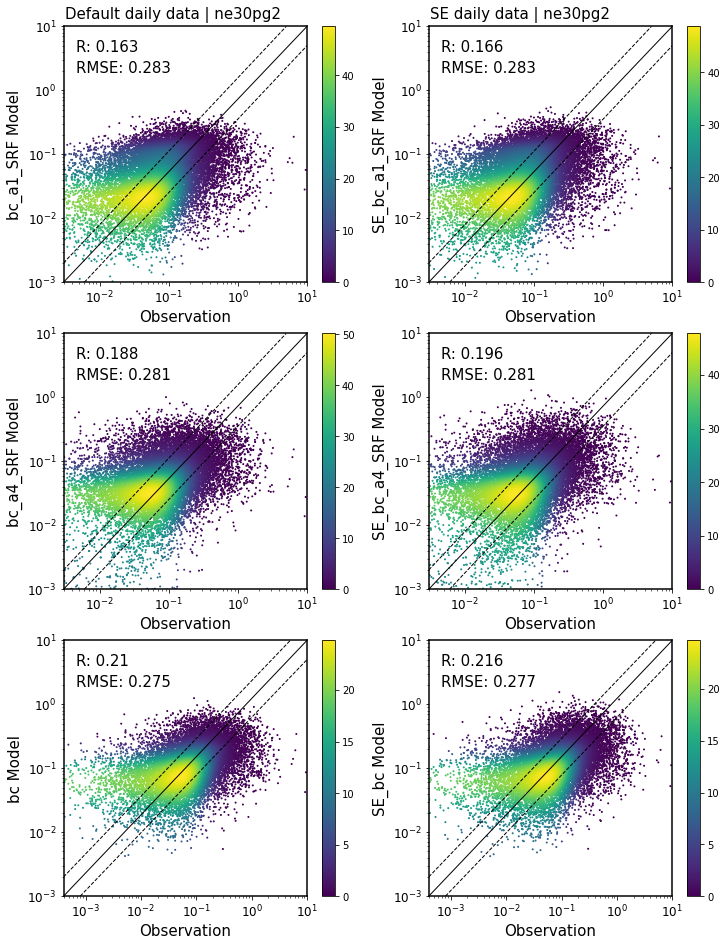

In [738]:
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy import stats
import mpl_scatter_density
##########################
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
plt.figure(figsize=(12,16))
i=1
for v in varbs:
    var = v+'_ne30pg2'
    ax=plt.subplot(3,2,i)
    # Calculate the point density
    corr=stats.pearsonr(df_nona['obs'],df_nona[var])
    xy = np.vstack([df_nona['obs'],df_nona[var]])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    improve_obs, mod, z_mod = df_nona['obs'][idx], df_nona[var][idx], z[idx]
    maxv = z_mod.max()
    #improve_obs, mod, z_mod = density_scatter(df['obs'], df['mod'])
    RMSE=np.sqrt(np.divide(np.sum(np.multiply((df_nona[var]-df_nona['obs']),(df_nona[var]-df_nona['obs']))),len(df_nona['obs'])))
    #heatmap = ax.scatter((improve_obs), (mod), c=z_mod, cmap=plt.cm.viridis,vmax=maxv,vmin=0)
    heatmap = ax.scatter(improve_obs, mod, c=z_mod, s=1, cmap=plt.cm.viridis, vmax=maxv, vmin=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if i==1:
        ax.text(0.005,1.03,'Default daily data | ne30pg2',size=15,transform=ax.transAxes)
    if i==2:
        ax.text(0.005,1.03,'SE daily data | ne30pg2',size=15,transform=ax.transAxes)
    ax.text(0.05,0.9,'R: '+str(np.round(corr[0],3)),size=15,transform=ax.transAxes)
    ax.text(0.05,0.82,'RMSE: '+str(np.round(RMSE,3)),size=15,transform=ax.transAxes)
    ##
    #x1 = mlines.Line2D([0, 1], [0, 1], color='k', linestyle='-',linewidth=1)
    #transform = ax.transAxes
    #x1.set_transform(transform)
    #ax.add_line(x1)
    plt.colorbar(heatmap)
    plt.setp(ax.spines.values(),lw=1.5)
    if (i==1) or (i==2):
        xx1=3e-3
    elif (i==3) or (i==4):
        xx1=3e-3
    else:
        xx1=4e-4
    xx2=1e1
    yy1=1e-3
    yy2=1e1
    plt.xlim([xx1,xx2]) # BC
    plt.ylim([yy1,yy2]) #BC
    ###########
    x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    ax.tick_params(labelsize=12)
    plt.ylabel(v+' Model',fontsize=15)
    plt.xlabel('Observation',fontsize=15)
    i+=1

plt.savefig('daily_BC_scatter_IMPROVE_ne30pg2.png',format='png',dpi=300,bbox_inches='tight',pad_inches=0.1)



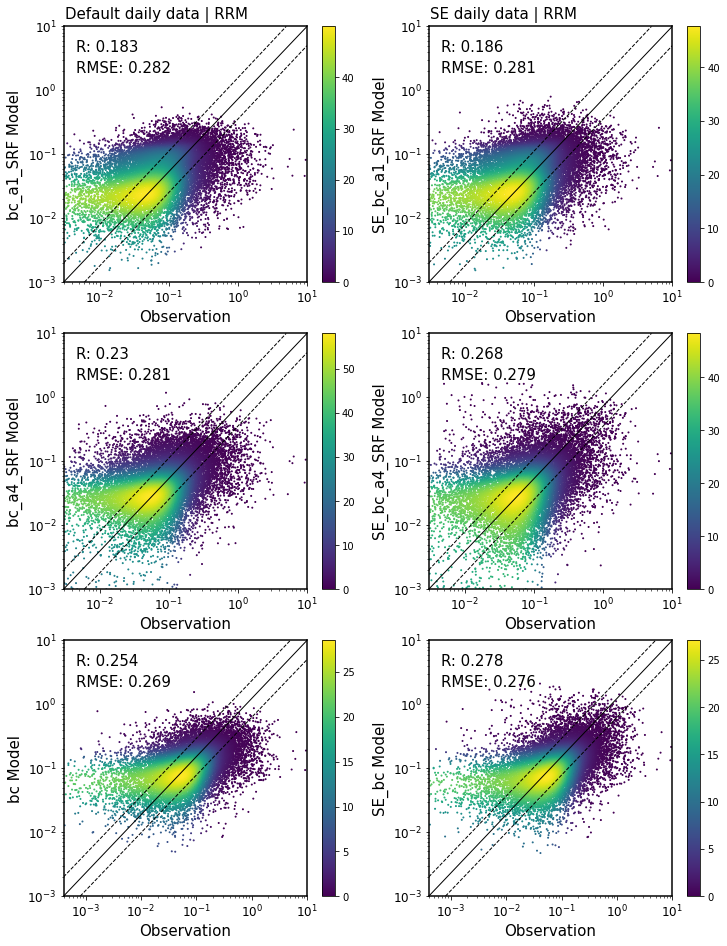

In [737]:
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy import stats
import mpl_scatter_density
##########################
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
plt.figure(figsize=(12,16))
i=1
for v in varbs:
    var = v+'_RRM'
    ax=plt.subplot(3,2,i)
    # Calculate the point density
    corr=stats.pearsonr(df_nona['obs'],df_nona[var])
    xy = np.vstack([df_nona['obs'],df_nona[var]])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    improve_obs, mod, z_mod = df_nona['obs'][idx], df_nona[var][idx], z[idx]
    maxv = z_mod.max()
    #improve_obs, mod, z_mod = density_scatter(df['obs'], df['mod'])
    RMSE=np.sqrt(np.divide(np.sum(np.multiply((df_nona[var]-df_nona['obs']),(df_nona[var]-df_nona['obs']))),len(df_nona['obs'])))
    #heatmap = ax.scatter((improve_obs), (mod), c=z_mod, cmap=plt.cm.viridis,vmax=maxv,vmin=0)
    heatmap = ax.scatter(improve_obs, mod, c=z_mod, s=1, cmap=plt.cm.viridis, vmax=maxv, vmin=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if i==1:
        ax.text(0.005,1.03,'Default daily data | RRM',size=15,transform=ax.transAxes)
    if i==2:
        ax.text(0.005,1.03,'SE daily data | RRM',size=15,transform=ax.transAxes)
    ax.text(0.05,0.9,'R: '+str(np.round(corr[0],3)),size=15,transform=ax.transAxes)
    ax.text(0.05,0.82,'RMSE: '+str(np.round(RMSE,3)),size=15,transform=ax.transAxes)
    ##
    #x1 = mlines.Line2D([0, 1], [0, 1], color='k', linestyle='-',linewidth=1)
    #transform = ax.transAxes
    #x1.set_transform(transform)
    #ax.add_line(x1)
    plt.colorbar(heatmap)
    plt.setp(ax.spines.values(),lw=1.5)
    if (i==1) or (i==2):
        xx1=3e-3
    elif (i==3) or (i==4):
        xx1=3e-3
    else:
        xx1=4e-4
    xx2=1e1
    yy1=1e-3
    yy2=1e1
    plt.xlim([xx1,xx2]) # BC
    plt.ylim([yy1,yy2]) #BC
    ###########
    x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    ax.tick_params(labelsize=12)
    plt.ylabel(v+' Model',fontsize=15)
    plt.xlabel('Observation',fontsize=15)
    i+=1

plt.savefig('daily_BC_scatter_IMPROVE_RRM.png',format='png',dpi=300,bbox_inches='tight',pad_inches=0.1)



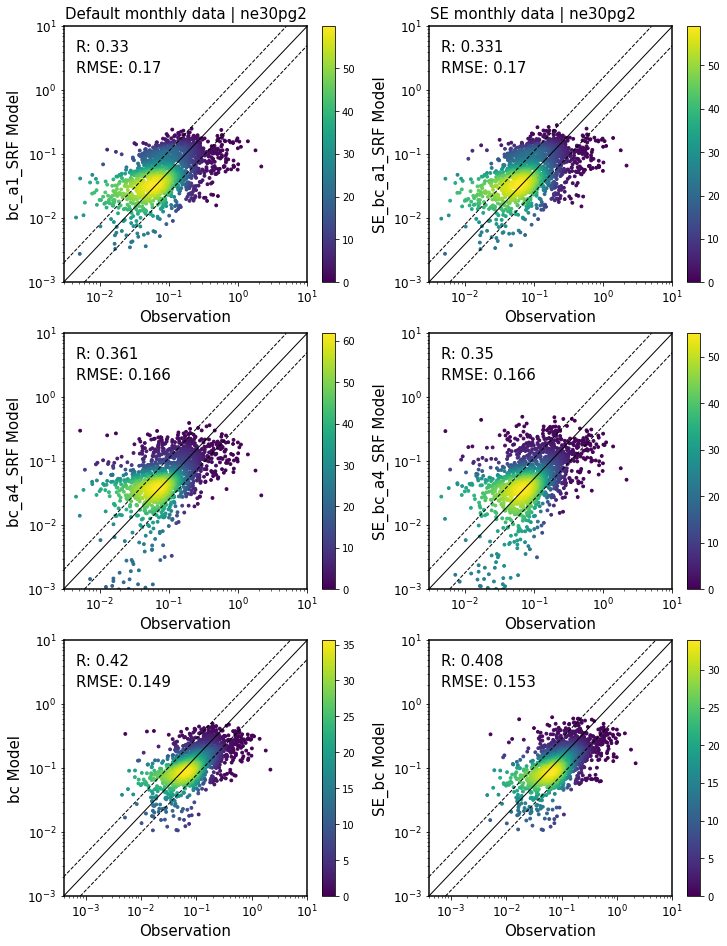

In [742]:
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy import stats
import mpl_scatter_density
##########################
df_monthly=df_nona.groupby('ncols_ne30pg2').resample('1M').mean().reset_index(drop=True)
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
plt.figure(figsize=(12,16))
i=1
for v in varbs:
    var = v+'_ne30pg2'
    ax=plt.subplot(3,2,i)
    # Calculate the point density
    corr=stats.pearsonr(df_monthly['obs'],df_monthly[var])
    xy = np.vstack([df_monthly['obs'],df_monthly[var]])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    improve_obs, mod, z_mod = df_monthly['obs'][idx], df_monthly[var][idx], z[idx]
    maxv = z_mod.max()
    #improve_obs, mod, z_mod = density_scatter(df['obs'], df['mod'])
    RMSE=np.sqrt(np.divide(np.sum(np.multiply((df_monthly[var]-df_monthly['obs']),(df_monthly[var]-df_monthly['obs']))),len(df_monthly['obs'])))
    #heatmap = ax.scatter((improve_obs), (mod), c=z_mod, cmap=plt.cm.viridis,vmax=maxv,vmin=0)
    heatmap = ax.scatter(improve_obs, mod, c=z_mod, s=8, cmap=plt.cm.viridis, vmax=maxv, vmin=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if i==1:
        ax.text(0.005,1.03,'Default monthly data | ne30pg2',size=15,transform=ax.transAxes)
    if i==2:
        ax.text(0.005,1.03,'SE monthly data | ne30pg2',size=15,transform=ax.transAxes)
    ax.text(0.05,0.9,'R: '+str(np.round(corr[0],3)),size=15,transform=ax.transAxes)
    ax.text(0.05,0.82,'RMSE: '+str(np.round(RMSE,3)),size=15,transform=ax.transAxes)

    plt.colorbar(heatmap)
    plt.setp(ax.spines.values(),lw=1.5)
    if (i==1) or (i==2):
        xx1=3e-3
    elif (i==3) or (i==4):
        xx1=3e-3
    else:
        xx1=4e-4
    xx2=1e1
    yy1=1e-3
    yy2=1e1
    plt.xlim([xx1,xx2]) # BC
    plt.ylim([yy1,yy2]) #BC
    ###########
    x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    ax.tick_params(labelsize=12)
    plt.ylabel(v+' Model',fontsize=15)
    plt.xlabel('Observation',fontsize=15)
    i+=1

plt.savefig('monthly_BC_scatter_IMPROVE_ne30pg2.png',format='png',dpi=300,bbox_inches='tight',pad_inches=0.1)



In [890]:
## Separate sites based on bias
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
df_yr_ne30pg2 = df_nona.groupby('ncols_ne30pg2').resample('1Y').mean().reset_index(drop=True)
df_yr_RRM = df_nona.groupby('ncols_RRM').resample('1Y').mean().reset_index(drop=True)
for var in varbs:
    df_yr_ne30pg2[var+'_bias_ne30pg2']=df_yr_ne30pg2[var+'_ne30pg2']-df_yr_ne30pg2['obs']
    df_yr_RRM[var+'_bias_RRM']=df_yr_RRM[var+'_RRM']-df_yr_RRM['obs']
## Get the improved and degraded sites
improved_sites_ne30 = df_yr_ne30pg2[df_yr_ne30pg2['SE_bc_bias_ne30pg2']<df_yr_ne30pg2['bc_bias_ne30pg2']]
degraded_sites_ne30 = df_yr_ne30pg2[df_yr_ne30pg2['SE_bc_bias_ne30pg2']>df_yr_ne30pg2['bc_bias_ne30pg2']]
improved_sites_RRM = df_yr_RRM[df_yr_RRM['SE_bc_bias_RRM']<df_yr_RRM['bc_bias_RRM']]
degraded_sites_RRM = df_yr_RRM[df_yr_RRM['SE_bc_bias_RRM']>df_yr_RRM['bc_bias_RRM']]
input=0
best_ne30pg2_25 = improved_sites_ne30.iloc[(improved_sites_ne30['SE_bc_bias_ne30pg2']-input).abs().argsort()[:25]]
best_RRM_25 = improved_sites_RRM.iloc[(improved_sites_RRM['SE_bc_bias_RRM']-input).abs().argsort()[:25]]
best_RRM_25[['bc_RRM','SE_bc_RRM','obs','SE_bc_bias_RRM','bc_bias_RRM']]

,bc_RRM,SE_bc_RRM,obs,SE_bc_bias_RRM,bc_bias_RRM
122,0.083898,0.076662,0.076577,0.000085,0.007321
119,0.091800,0.078504,0.078641,-0.000136,0.013159
137,0.032577,0.032559,0.030842,0.001718,0.001735
110,0.099608,0.099166,0.096789,0.002377,0.002819
86,0.195091,0.159180,0.155948,0.003232,0.039143
141,0.104506,0.075773,0.079186,-0.003413,0.025320
142,0.074548,0.070725,0.065393,0.005331,0.009154
138,0.053535,0.046180,0.039726,0.006454,0.013810
23,0.120857,0.118063,0.111031,0.007032,0.009827
59,0.176013,0.162343,0.169434,-0.007091,0.006579


In [893]:
degraded_sites_RRM['ncols_RRM'].astype(int).values

array([12229, 12235, 29309, 31469, 31546, 33103, 33127, 33171, 33175,
       33260, 33264, 33267, 33305, 33314, 33380, 33453, 33457, 33489,
       33569, 33590, 33603, 33609, 33926, 34150, 34279, 34439, 34471,
       34476, 34504, 34591, 34731, 35960, 35965, 36071, 36081, 36145,
       36481, 36501, 36929, 37672, 37816, 37894, 38113, 38211, 38676,
       39993, 40035, 40050, 45348, 45507, 48987, 49026, 49079, 50716,
       50811, 50869, 50901, 52442, 52563, 52653, 52806, 52857, 52858,
       52878, 53718, 54238, 54384, 54414, 57375])

In [ ]:
best_ne30pg2['ncols_ne30pg2'].astype(int).values

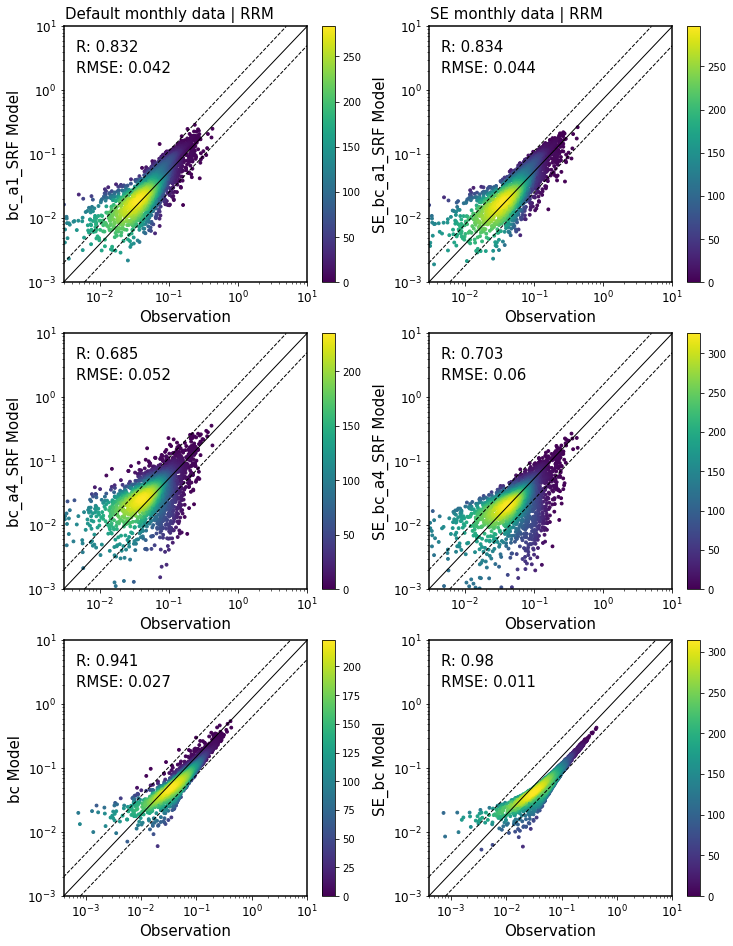

In [889]:
## Scatter plots with improved sites
## daily data
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
#df_yr_ne30pg2 = df_nona.groupby('ncols_ne30pg2').resample('1Y').mean().reset_index(drop=True)
#df_yr_RRM = df_nona.groupby('ncols_RRM').resample('1Y').mean().reset_index(drop=True)
for var in varbs:
    df_nona[var+'_bias_ne30pg2']=df_nona[var+'_ne30pg2']-df_nona['obs']
    df_nona[var+'_bias_RRM']=df_nona[var+'_RRM']-df_nona['obs']
## Get the improved and degraded sites
improved_sites_ne30 = df_nona[df_nona['SE_bc_bias_ne30pg2']<df_nona['bc_bias_ne30pg2']]
degraded_sites_ne30 = df_nona[df_nona['SE_bc_bias_ne30pg2']>df_nona['bc_bias_ne30pg2']]
imp_ne30_1sd=improved_sites_ne30[improved_sites_ne30['SE_bc_bias_ne30pg2']<=improved_sites_ne30['SE_bc_bias_ne30pg2'].std()]
input=0
best_ne30pg2 = improved_sites_ne30.iloc[(improved_sites_ne30['SE_bc_bias_ne30pg2']-input).abs().argsort()[:4000]]
best_ne30pg2_annual = best_ne30pg2.groupby('ncols_ne30pg2').mean().reset_index(drop=True)

improved_sites_RRM = df_nona[df_nona['SE_bc_bias_RRM']<df_nona['bc_bias_RRM']]
degraded_sites_RRM = df_nona[df_nona['SE_bc_bias_RRM']>df_nona['bc_bias_RRM']]
imp_ne30_1sd=improved_sites_ne30[improved_sites_ne30['SE_bc_bias_ne30pg2']<=improved_sites_ne30['SE_bc_bias_ne30pg2'].std()]
input=0
best_RRM = improved_sites_RRM.iloc[(improved_sites_RRM['SE_bc_bias_RRM']-input).abs().argsort()[:2000]]
#######
improved_sites_RRM = df_nona[df_nona['SE_bc_a1_SRF_bias_RRM']<df_nona['bc_a1_SRF_bias_RRM']]
## improved sites within 1SD of 0
imp_ne30pg2_1sd=improved_sites_RRM[improved_sites_RRM['bc_bias_ne30pg2']<=0.1*improved_sites_RRM['bc_bias_ne30pg2'].std()]
degraded_sites_RRM = df_nona[df_nona['SE_bc_a1_SRF_bias_RRM']>df_nona['bc_a1_SRF_bias_RRM']]
#################################
##################################
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy import stats
import mpl_scatter_density
##########################
df_monthly=best_RRM
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
plt.figure(figsize=(12,16))
i=1
for v in varbs:
    var = v+'_RRM'
    ax=plt.subplot(3,2,i)
    # Calculate the point density
    corr=stats.pearsonr(df_monthly['obs'],df_monthly[var])
    xy = np.vstack([df_monthly['obs'],df_monthly[var]])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    improve_obs, mod, z_mod = df_monthly['obs'][idx], df_monthly[var][idx], z[idx]
    maxv = z_mod.max()
    #improve_obs, mod, z_mod = density_scatter(df['obs'], df['mod'])
    RMSE=np.sqrt(np.divide(np.sum(np.multiply((df_monthly[var]-df_monthly['obs']),(df_monthly[var]-df_monthly['obs']))),len(df_monthly['obs'])))
    #heatmap = ax.scatter((improve_obs), (mod), c=z_mod, cmap=plt.cm.viridis,vmax=maxv,vmin=0)
    heatmap = ax.scatter(improve_obs, mod, c=z_mod, s=8, cmap=plt.cm.viridis, vmax=maxv, vmin=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if i==1:
        ax.text(0.005,1.03,'Default monthly data | RRM',size=15,transform=ax.transAxes)
    if i==2:
        ax.text(0.005,1.03,'SE monthly data | RRM',size=15,transform=ax.transAxes)
    ax.text(0.05,0.9,'R: '+str(np.round(corr[0],3)),size=15,transform=ax.transAxes)
    ax.text(0.05,0.82,'RMSE: '+str(np.round(RMSE,3)),size=15,transform=ax.transAxes)

    plt.colorbar(heatmap)
    plt.setp(ax.spines.values(),lw=1.5)
    if (i==1) or (i==2):
        xx1=3e-3
    elif (i==3) or (i==4):
        xx1=3e-3
    else:
        xx1=4e-4
    xx2=1e1
    yy1=1e-3
    yy2=1e1
    plt.xlim([xx1,xx2]) # BC
    plt.ylim([yy1,yy2]) #BC
    ###########
    x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    ax.tick_params(labelsize=12)
    plt.ylabel(v+' Model',fontsize=15)
    plt.xlabel('Observation',fontsize=15)
    i+=1

plt.savefig('daily_BC_scatter_IMPROVE_RRM_best_25p_improvedSites.png',format='png',dpi=300,bbox_inches='tight',pad_inches=0.1)



In [863]:
improved_sites_ne30 = df_nona[df_nona['SE_bc_bias_ne30pg2']<df_nona['bc_bias_ne30pg2']]
imp_ne30_1sd=improved_sites_ne30[improved_sites_ne30['SE_bc_bias_ne30pg2']<=improved_sites_ne30['SE_bc_bias_ne30pg2'].std()]
imp_ne30_1sd[['bc_ne30pg2','SE_bc_ne30pg2','obs','SE_bc_a1_SRF_bias_ne30pg2','bc_a1_SRF_bias_ne30pg2']]
len(degraded_sites_ne30['ncols_ne30pg2'].unique())


122

In [859]:
#imp_ne30_1sd=improved_sites_ne30[improved_sites_ne30['SE_bc_bias_ne30pg2']<=0.1*improved_sites_ne30['SE_bc_bias_ne30pg2'].std()]
#imp_ne30_1sd[['bc_ne30pg2','SE_bc_ne30pg2','obs','SE_bc_a1_SRF_bias_ne30pg2','bc_a1_SRF_bias_ne30pg2']]
df_nona.sort_values(by=['SE_bc_bias_ne30pg2'],ascending=False)
input=0
best_ne30pg2 = improved_sites_ne30.iloc[(improved_sites_ne30['SE_bc_bias_ne30pg2']-input).abs().argsort()[:2000]]
best_ne30pg2_ncols = best_ne30pg2.groupby(['ncols_ne30pg2']).resample('1M').mean()
len(improved_sites_ne30['ncols_ne30pg2'].unique())


116

In [887]:
improved_sites_RRM = df_nona[df_nona['SE_bc_bias_RRM']<df_nona['bc_bias_RRM']]
degraded_sites_RRM = df_nona[df_nona['SE_bc_bias_RRM']>df_nona['bc_bias_RRM']]
imp_ne30_1sd=improved_sites_ne30[improved_sites_ne30['SE_bc_bias_ne30pg2']<=improved_sites_ne30['SE_bc_bias_ne30pg2'].std()]
input=0
best_RRM = improved_sites_RRM.iloc[(improved_sites_RRM['SE_bc_bias_RRM']-input).abs().argsort()[:]]
best_RRM


,time,ncol,bc_a1_SRF,bc_a1_SRF_ne30pg2,SE_bc_a1_SRF_ne30pg2,bc_a3_SRF_ne30pg2,SE_bc_a3_SRF_ne30pg2,bc_a4_SRF_ne30pg2,SE_bc_a4_SRF_ne30pg2,bc_ne30pg2,...,SE_bc_a1_SRF_bias_ne30pg2,SE_bc_a1_SRF_bias_RRM,bc_a4_SRF_bias_ne30pg2,bc_a4_SRF_bias_RRM,SE_bc_a4_SRF_bias_ne30pg2,SE_bc_a4_SRF_bias_RRM,bc_bias_ne30pg2,bc_bias_RRM,SE_bc_bias_ne30pg2,SE_bc_bias_RRM
2016-05-09,2016-05-09,164,0.036318,0.036318,0.029937,0.001418,0.001367,0.022820,0.020735,0.060556,...,-0.028073,-0.014233,-0.035190,-0.042385,-0.037275,-0.045336,0.002546,0.001562,-0.005971,-0.000005
2016-04-15,2016-04-15,89,0.014903,0.014903,0.015152,0.000684,0.000697,0.017316,0.022408,0.032902,...,-0.028398,-0.019598,-0.026234,-0.024421,-0.021142,-0.025074,-0.010648,0.000885,-0.005293,0.000012
2016-10-15,2016-10-15,119,0.142542,0.142542,0.161576,0.001326,0.001141,0.151685,0.202653,0.295553,...,0.065546,-0.055254,0.055655,-0.035168,0.106623,-0.041746,0.199523,0.014779,0.269341,-0.000015
2016-01-04,2016-01-04,132,0.094069,0.094069,0.100741,0.000678,0.000713,0.164136,0.168079,0.258883,...,0.043311,-0.012119,0.106706,-0.034176,0.110649,-0.046346,0.201453,0.015448,0.212103,-0.000030
2016-06-14,2016-06-14,83,0.013349,0.013349,0.013834,0.002234,0.001844,0.005651,0.005045,0.021235,...,-0.015916,-0.009408,-0.024099,-0.022246,-0.024705,-0.024269,-0.008515,0.000333,-0.009027,-0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-07,2016-08-07,130,0.132441,0.132441,0.124880,0.006188,0.005538,0.056366,0.048411,0.194996,...,-2.370090,-2.382413,-2.438604,-2.468963,-2.446559,-2.473914,-2.299974,-2.348754,-2.316141,-2.354521
2016-01-13,2016-01-13,99,0.039891,0.039891,0.040611,0.000209,0.000187,0.078740,0.074931,0.118840,...,-2.619539,-2.620868,-2.581410,-2.607518,-2.585219,-2.611672,-2.541310,-2.562632,-2.544421,-2.572033
2016-08-01,2016-08-01,130,0.075611,0.075611,0.080655,0.000723,0.000742,0.040504,0.051963,0.116838,...,-5.198835,-5.215914,-5.238986,-5.248853,-5.227527,-5.248286,-5.162652,-5.183790,-5.146130,-5.183812
2016-02-18,2016-02-18,27,0.087116,0.087116,0.087342,0.000522,0.000537,0.052792,0.035780,0.140430,...,-5.520238,-5.530149,-5.554789,-5.506935,-5.571800,-5.544333,-5.467150,-5.421389,-5.483921,-5.466110
